In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import scipy

In [258]:
# This is a mess due to historical changes. Need to clean up to create a list of behaviors and candidate SNPs
maclean = pd.read_csv("/seq/vgb/bryc/projects/dog_behavioral_gwas_paper/data/Maclean_sig_SNPs.csv", header=None)
marker_to_behavior = {
    "chr1:42445143": ['2','4', '5', '6', '8', '11', '13', '108', '228',  "factor_2"],
    "chr10:8354804": ['41', '107', '109', 'factor_8', '37', '82', '83', '88', '166'],
    "chr10:8415970": ['41', '107', '109', 'factor_8'],
    "chr10:8752420": ['41', '107', '109', 'factor_8'],
    "chr10:8808920": ['71', '73', '75', 'factor_6', '41', '107', '109', 'factor_8'],
    "chr10:2790081": ['11', '42', '46', '167', '170', '171', '175', '37', '41', '82', '83', '88', '166', '71', '73', '75', 'factor_6'],
    "chr15:41524634": ['37', '41', '82', '83', '88', '166'],
    "chr15:41543072": ['37', '41', '82', '83', '88', '166'],
    "chr18:20591145": ['74', '75', '77', "factor_6", '37', '41', '82', '83', '88', '166', '21', '23', '31', '34', '53', '57', '11', '42', '46', '167', '170', '171', '175'],
    "chr34:18730331": ['74', '75', '77', "factor_6", '41', '107', '109', 'factor_8'],
#    "chrX:103473176" : ['74', '75', '77', "factor_6"],
#    "chrX:104047776" : ['74', '75', '77', "factor_6"],
}
marker_to_behavior.update(dict(zip(maclean[0], maclean[1].str.split(','))))

marker_to_morphology = {
    "chr1:42445143": ['246'],
    "chr34:18730331": ['121'],
    "chr10:8354804": ['125', '121'],
    "chr10:8415970": ['125', '121'],
    "chr10:8752420": ['125', '121'],
    "chr10:8808920": ['125', '121'],
    "chr10:2790081":['121', '125'],
    "chr15:41543072": ['121'],
    "chr18:20591145": ['121', '246'],
    #"chr12:57877660": ['122'],
    ##"chr11:33520295": ['122'],
    #"chr12:60476684": ['122'],
    "chr32:33275351": ['127']
    
}
all_morphology = ['121', '125', '126', '127', '246']

all_behavior = []
for behavior_list in marker_to_behavior.values():
    all_behavior.extend(behavior_list)
all_behavior = list(set(all_behavior))

#all_sites = list(set(list(marker_to_morphology.keys()) + list(marker_to_behavior.keys())))

all_sites = pd.read_csv("/seq/vgb/bryc/projects/dog_behavioral_gwas_paper/data/candidate_SNPs.csv",header=None)[0].to_list()
print(all_morphology)
print(all_behavior)
print(all_sites)

['121', '125', '126', '127', '246']
['41', '4', '170', '31', '42', '2', '108', '175', '77', '53', '73', '23', '57', 'factor_6', '37', '51', '71', '19', '21', '34', '167', '88', '13', '75', '81', '84', 'factor_8', '16', '228', '107', '86', '109', 'factor_4', '82', '8', '48', '44', '74', '166', '5', '90', '11', '83', '165', 'factor_2', '6', '171', '46']
['chr1:22232413', 'chr1:42445143', 'chr1:58953964', 'chr1:62681369', 'chr1:66319648', 'chr1:81715878', 'chr1:97177262', 'chr10:2790081', 'chr10:44543882', 'chr10:8354804', 'chr10:8808920', 'chr11:33520295', 'chr12:57877660', 'chr12:60476684', 'chr13:12028649', 'chr13:8968309', 'chr14:15006461', 'chr15:41524634', 'chr15:41543072', 'chr16:15985495', 'chr16:37711564', 'chr16:58383594', 'chr16:7682829', 'chr16:7693015', 'chr16:7712940', 'chr17:41469226', 'chr18:20591145', 'chr18:30339993', 'chr2:18679362', 'chr2:18691507', 'chr20:29878200', 'chr21:46094520', 'chr21:46097212', 'chr22:44703213', 'chr23:39052230', 'chr23:39058824', 'chr23:390655

In [259]:
height_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_AgeComposed_Height_N-3277.tsv"
neuter_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_Sex_NeuterStatus_N-3277.tsv"
pheno_file="/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/2024-10-15_merged_phenotype_table.csv"
geno_file="/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/target_sites_genotypes.csv"

In [260]:
# Load dataframes
ph = pd.read_csv(pheno_file)
genos = pd.read_csv(geno_file)
height = pd.read_csv(height_file, sep = "\t",header=None, names = ["fam_id", "dog", "age", "height"])
neuter = pd.read_csv(neuter_file, sep = "\t", header=None, names = ["fam_id", "dog", "sex", "neuter"])

/local/scratch/47441816.1.interactive/ipykernel_36774/2982985312.py:2: DtypeWarning: Columns (15,259,260) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv(pheno_file)


In [261]:
merge = ph.merge(genos, left_on='id', right_on='dog')
merge2 = merge.merge(height, left_on='id', right_on="dog")
merge2.columns = merge2.columns.str.replace(' ', '_')
merge2['sex'] = merge2.sex.replace({'male': 0, 'female':1})

In [262]:
# Make mixed breed dog dataframe
PUREBRED_CUTOFF = 0.85

breeds = merge2.columns[19:131]
purebred_dogs = merge2.id[merge2.purebred == "yes"].to_list()
for breed in breeds:
    purebreds_breed = merge2.id[merge2[breed] > PUREBRED_CUTOFF].to_list()
    if len(purebreds_breed) > 0:
        purebred_dogs.extend(purebreds_breed)
mixed = merge2[~merge2.id.isin(purebred_dogs)].copy()

In [263]:
merge2[merge2.id.isin(purebred_dogs)].breed1.value_counts().to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/purebred_breed_counts.csv")

# Run likelihoods test for  dogs

In [264]:
# Clear outfile:
LRT_FILE = '/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/all_by_all_full_vs_reduced_LRTs.csv'
with open(LRT_FILE, 'w'):
    print("")

def run_likelihood_tests(snp_list,
                         pheno_list,
                         df, 
                         size_covariates = True, 
                         ancestries = None, 
                         ancestry_dict = None, 
                         outfile = LRT_FILE):   
    results = []
    with open(outfile, 'a') as fh:
        for snp in snp_list: 
            if ancestry_dict is not None:
                ancestries = ancestry_dict[snp]
            if ancestries is not None:
                ancestries_cov = " + " + " + ".join(ancestries)
            else:
                ancestries_cov = ""
            for pheno in pheno_list:
                # OLS is _very_ finicky about column names so we will copy ours over to "clean" names here
                df['test_snp'] = df[snp]
                df['phenotype'] = df[pheno]
                df['leg_length'] = df['246']
                if size_covariates == False:
                    formula_text = 'phenotype ~ age_y + C(sex) + C(neutered)  + test_snp'
                    reduced_formula_text='phenotype ~ age_y + C(sex) + C(neutered)'
                elif pheno == '121':
                    formula_text = 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp'
                    reduced_formula_text='phenotype ~ leg_length + age_y + C(sex) + C(neutered)'
                elif pheno == '246':
                    formula_text = 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp'
                    reduced_formula_text='phenotype ~ height + age_y + C(sex) + C(neutered)'
                else:
                    formula_text = 'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp'
                    reduced_formula_text='phenotype ~ height + leg_length + age_y + C(sex) + C(neutered)'

                full_model = smf.ols(formula= formula_text + ancestries_cov,
                                     data=df)
                full_res = full_model.fit()
                fh.write(f"\nFull model OLS for phenotype: {pheno}, test_snp: {snp}\n")
                fh.write(full_res.summary().as_csv())
                full_ll = full_res.llf

                reduced_model = smf.ols(formula= reduced_formula_text + ancestries_cov,
                                        data=df)
                reduced_res = reduced_model.fit()
                fh.write(f"\nReduced model OLS for phenotype: {pheno}, test_snp: {snp}\n")
                fh.write(reduced_res.summary().as_csv())
                reduced_ll = reduced_res.llf

                #calculate likelihood ratio Chi-Squared test statistic
                LR_statistic = -2*(reduced_ll-full_ll)
                fh.write(f"\n\nLikelihood Ratio Test:\nFull vs reduced LR statistic: {LR_statistic}\n")


                #calculate p-value of test statistic using degrees of freedom
                p_val = scipy.stats.chi2.sf(LR_statistic, 1)
                fh.write(f"\nP-value for chi squared with 1 df: {p_val}\n\n\n")
                ancestry_text = ""
                if ancestries is not None:
                    ancestry_text = " + breed_ancestry_estimates"

                results.append({"model": formula_text + ancestry_text + "; N = "+ str(len(df)) , "locus":snp, "pheno": pheno, "LRT p-value": p_val})
    return results

In [265]:
morphology_no_size_all = run_likelihood_tests(all_sites, all_morphology, merge2, size_covariates = False)
behavior_no_size_all = run_likelihood_tests(all_sites, all_behavior, merge2, size_covariates = False)

morphology_no_size_mixed = run_likelihood_tests(all_sites, all_morphology, mixed, size_covariates = False)
behavior_no_size_mixed = run_likelihood_tests(all_sites, all_behavior, mixed, size_covariates = False)

morphology_results_all = run_likelihood_tests(all_sites, all_morphology, merge2)
behavior_results_all = run_likelihood_tests(all_sites, all_behavior, merge2)

morphology_results_mixed = run_likelihood_tests(all_sites, all_morphology, mixed)
behavior_results_mixed = run_likelihood_tests(all_sites, all_behavior, mixed)

## Find correlation between SNPs and breed ancestries

In [266]:
breed_list = list(breeds)
breeds_to_drop = ["Alaskan_Sled_Dog", "Village_Dog_(China)", "Lagotti_Romagnoli",
                 "Belgian_Sheepdog", "Bouvier_Des_Flanders", "Greenland_Sled_Dog",
                 "Norwich_Terrier", "Sloughi", "Standard_Schnauzer",
                 "Village_Dog_(Nigeria)", "Village_Dog_(Vietnam)"]
for breed in breeds_to_drop:
    breed_list.remove(breed)

In [267]:
col_list = breed_list + list(all_sites)
snp_anc_df = merge2[col_list]
corr = snp_anc_df.corr(method="spearman")
snp_corrs = corr.loc[breed_list,
                     all_sites]
snp_corrs.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/snp_correlation.csv")

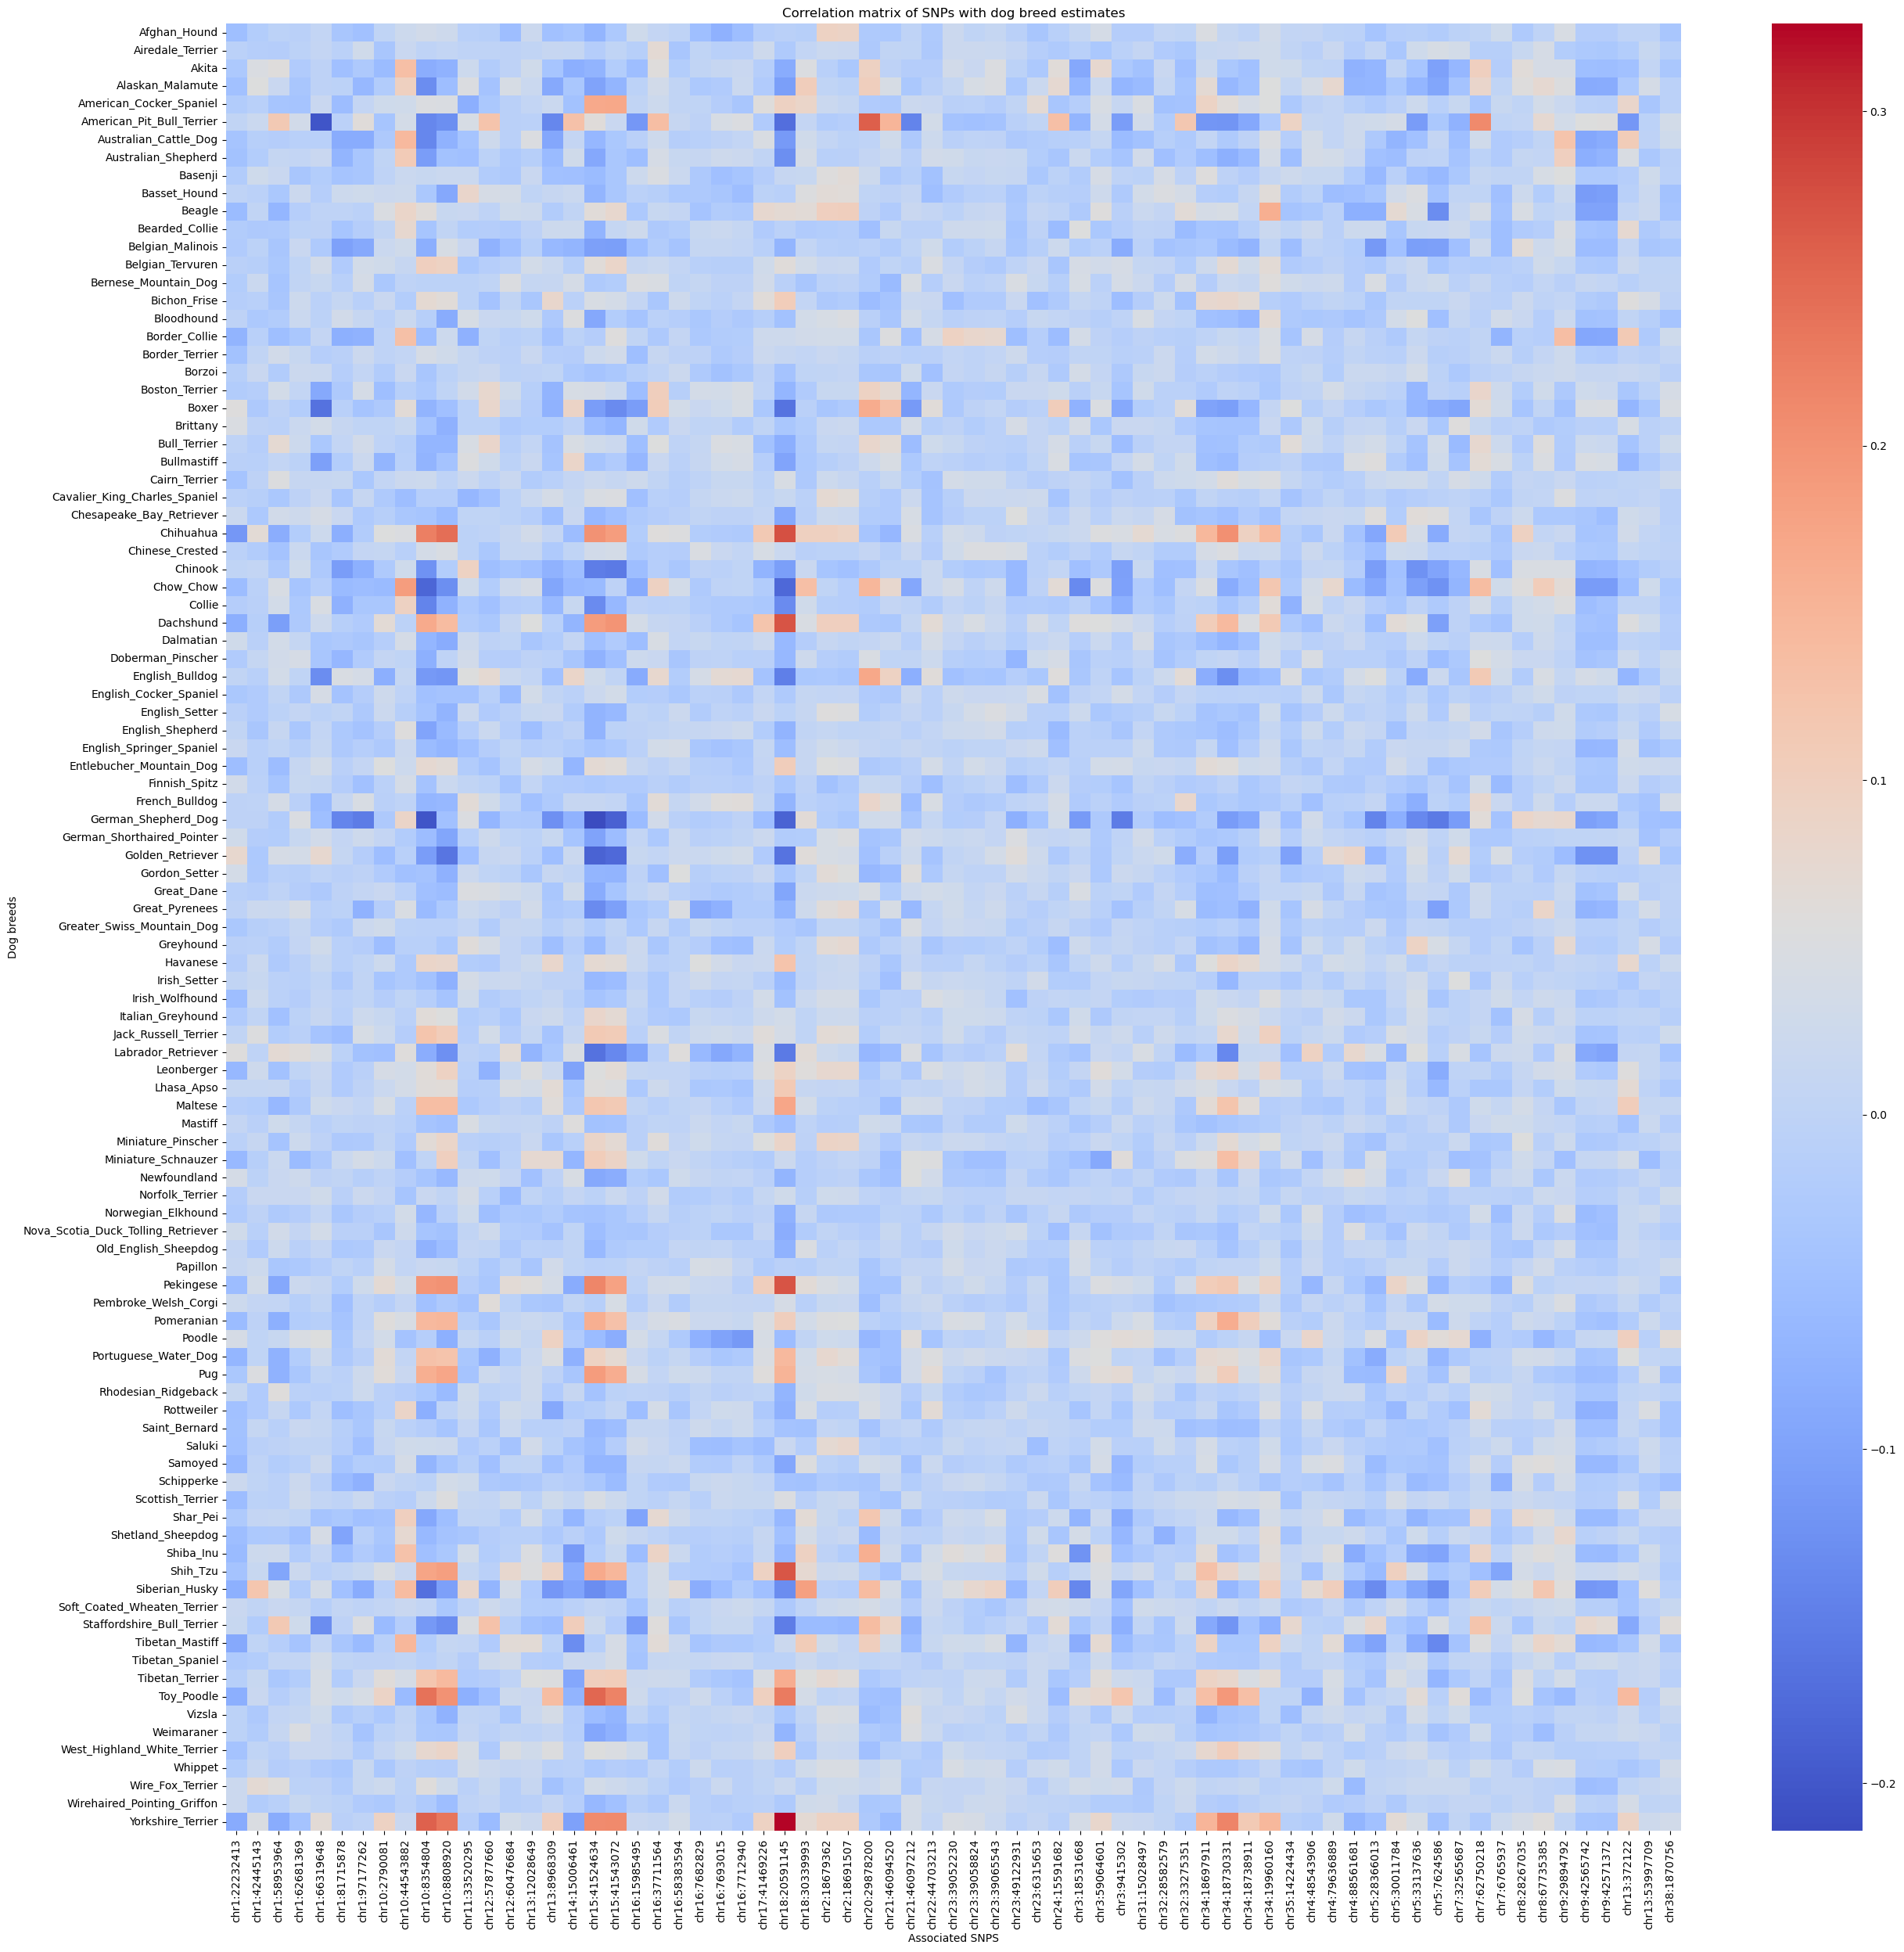

In [268]:
plt.figure(figsize=(30,30))
sns.heatmap(snp_corrs, annot = False, cmap='coolwarm')
plt.title("Correlation matrix of SNPs with dog breed estimates")
plt.xlabel("Associated SNPS")
plt.ylabel("Dog breeds")
plt.savefig("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/snp_correlation_with_breed_spearman.png", dpi=300)

In [269]:
top_five_breeds = {}
for snp in all_sites:
    top_five_breeds[snp] = list(snp_corrs.sort_values(snp,key=abs,ascending=False).index[:5])

In [270]:
pd.DataFrame(zip(top_five_breeds.keys(), top_five_breeds.values()), columns = ["SNP", "top_associated_breeds"]).to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/snp_top_breed_associations.csv")

In [271]:
# Most commonly associated breeds
from collections import Counter
top_correlated_ancestries = []
for ancs in top_five_breeds.values():
    top_correlated_ancestries.extend(ancs)
Counter(top_correlated_ancestries)

Counter({'Chihuahua': 19,
         'Tibetan_Mastiff': 12,
         'Yorkshire_Terrier': 17,
         'Dachshund': 11,
         'Toy_Poodle': 17,
         'Siberian_Husky': 24,
         'Wire_Fox_Terrier': 1,
         'Alaskan_Malamute': 6,
         'Jack_Russell_Terrier': 1,
         'American_Pit_Bull_Terrier': 20,
         'Staffordshire_Bull_Terrier': 11,
         'Shih_Tzu': 7,
         'Pekingese': 12,
         'Labrador_Retriever': 11,
         'Miniature_Schnauzer': 5,
         'German_Shepherd_Dog': 22,
         'Weimaraner': 1,
         'Poodle': 9,
         'Boxer': 11,
         'English_Bulldog': 11,
         'Bullmastiff': 2,
         'Chinook': 6,
         'Belgian_Malinois': 5,
         'Shetland_Sheepdog': 3,
         'Australian_Cattle_Dog': 5,
         'Chow_Chow': 17,
         'Akita': 4,
         'Basset_Hound': 4,
         'American_Cocker_Spaniel': 3,
         'Bull_Terrier': 2,
         'Boston_Terrier': 2,
         'English_Cocker_Spaniel': 2,
         'Shiba_Inu

In [272]:
# Most strongly correlated breeds
limit = 0.23
for x, y in zip(np.where(abs(snp_corrs) > limit)[0], np.where(abs(snp_corrs) > limit)[1]):
    print((snp_corrs.index[x]), snp_corrs.columns[y], snp_corrs.iloc[x, y])

American_Pit_Bull_Terrier chr20:29878200 0.26010261837686705
Chihuahua chr10:8808920 0.24217698469824697
Chihuahua chr18:20591145 0.27495090948332956
Dachshund chr18:20591145 0.26972446862240845
Pekingese chr18:20591145 0.2704979605852957
Shih_Tzu chr18:20591145 0.26811075914110183
Toy_Poodle chr10:8354804 0.2379097284749937
Toy_Poodle chr15:41524634 0.2507214405118823
Yorkshire_Terrier chr10:8354804 0.25721338872503463
Yorkshire_Terrier chr10:8808920 0.23456051388475474
Yorkshire_Terrier chr18:20591145 0.32626017212523256


# Add in breed estimates

In [273]:
ancestry_list = ["Labrador_Retriever", "Golden_Retriever", "German_Shepherd_Dog", "Yorkshire_Terrier", "Chihuahua"]
morphology_anc_all = run_likelihood_tests(all_sites, all_morphology, merge2, ancestry_dict = top_five_breeds)
behavior_anc_all = run_likelihood_tests(all_sites, all_behavior, merge2, ancestry_dict = top_five_breeds)

morphology_anc_mixed = run_likelihood_tests(all_sites, all_morphology, mixed, ancestry_dict = top_five_breeds)
behavior_anc_mixed = run_likelihood_tests(all_sites, all_behavior, mixed, ancestry_dict = top_five_breeds)

In [274]:
behavior_results = behavior_results_all + behavior_no_size_all + behavior_results_mixed + behavior_no_size_mixed + \
                   behavior_anc_all + behavior_anc_mixed
behavior_results = pd.DataFrame(behavior_results).pivot(index = ['locus', 'pheno'], columns = 'model', values = 'LRT p-value').reset_index()
behavior_results['phenotype_type'] = "behavior"

morphology_results = morphology_results_all +  morphology_no_size_all + \
                     morphology_results_mixed + morphology_no_size_mixed  +\
                     morphology_anc_all  + morphology_anc_mixed 
morphology_results = pd.DataFrame(morphology_results).pivot(index = ['locus', 'pheno'], columns = 'model', values = 'LRT p-value').reset_index()
morphology_results['phenotype_type'] = "aesthetic"

results = pd.concat([behavior_results, morphology_results])

In [275]:
questions_file = "/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/questions.csv"
quest = pd.read_csv(questions_file)
id_to_string = dict(zip(quest.id.astype(str), quest.string))

results['question'] = results.pheno.map(id_to_string)
results.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/all-by-all_combined_prediction_pvalues_top_ancs_spearman.csv", index=False)

In [276]:
morphology_results.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/morphology_prediction_pvalues_top_ancs_spearman.csv", index=False)
behavior_results.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/behavior_prediction_pvalues_top_ancs_spearman.csv", index=False)

In [277]:
fill_na_map = [['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 2454', 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 2454'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 3277', 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 3277'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 2454', 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp; N = 2454'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 3277', 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp; N = 3277'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 2454', 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp + breed_ancestry_estimates; N = 2454'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 3277', 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp + breed_ancestry_estimates; N = 3277'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 2454', 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp; N = 2454'],
       ['phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 3277', 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp; N = 3277'],
]
filled_results = results
for key, value in fill_na_map:
    filled_results[key] = filled_results[key].fillna(filled_results[value])
to_drop = [ 9, 10,11,12,13,14,15,16]
filled_results = filled_results.drop(filled_results.columns[to_drop], axis = 1)
filled_results.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/simplified_LRT_pvalues.csv")

In [278]:
filled_results

model,locus,pheno,phenotype ~ age_y + C(sex) + C(neutered) + test_snp; N = 2454,phenotype ~ age_y + C(sex) + C(neutered) + test_snp; N = 3277,phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 2454,phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 3277,phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 2454,phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 3277,phenotype_type,question
0,chr10:2790081,107,0.679675,0.939763,0.906030,0.465856,0.958356,0.465942,behavior,DOG is affectionate
1,chr10:2790081,108,0.797205,0.439582,0.164672,0.313668,0.154170,0.349181,behavior,DOG tends to be calm
2,chr10:2790081,109,0.030542,0.169281,0.115346,0.131753,0.137356,0.168857,behavior,DOG is aloof
3,chr10:2790081,11,0.466454,0.254187,0.317351,0.168267,0.450144,0.243288,behavior,DOG is relaxed when greeting people
4,chr10:2790081,13,0.133359,0.057875,0.009024,0.010109,0.028393,0.017950,behavior,DOG is boisterous
...,...,...,...,...,...,...,...,...,...,...
340,chr9:42571372,121,0.064877,0.438923,0.081739,0.584898,0.006828,0.062973,aesthetic,When DOG is standing next to someone of averag...
341,chr9:42571372,125,0.275389,0.912257,0.545435,0.886246,0.317270,0.975249,aesthetic,What is DOG's ear shape? Select the image with...
342,chr9:42571372,126,0.694214,0.481050,0.673328,0.645071,0.860864,0.870371,aesthetic,Are DOG's eyes different colors?
343,chr9:42571372,127,0.058229,0.002132,0.462897,0.240234,0.355815,0.140864,aesthetic,How long is DOG's fur on HIS back and sides? ...


In [279]:
results_stacked = pd.DataFrame(filled_results.set_index(['locus', 'pheno', 'question', 'phenotype_type']).stack()).reset_index()

In [280]:
results_stacked.rename(columns={0:"p-value"}, inplace=True)
simple_names = {'phenotype ~ age_y + C(sex) + C(neutered)  + test_snp; N = 2454': 'Mixed breed, basic covariates',
                'phenotype ~ age_y + C(sex) + C(neutered)  + test_snp; N = 3277' : "All dogs, basic covariates",
                'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 2454': "Mixed breed, size and ancestry covariates",
                'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp + breed_ancestry_estimates; N = 3277': "All dogs, size and ancestry covariates",
                'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 2454': "Mixed breed, size covariates",
                'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp; N = 3277': "All dogs, size covariates"}
results_stacked.model.replace(simple_names, inplace=True)
results_stacked.model.value_counts()

Mixed breed, basic covariates                3657
All dogs, basic covariates                   3657
Mixed breed, size and ancestry covariates    3657
All dogs, size and ancestry covariates       3657
Mixed breed, size covariates                 3657
All dogs, size covariates                    3657
Name: model, dtype: int64

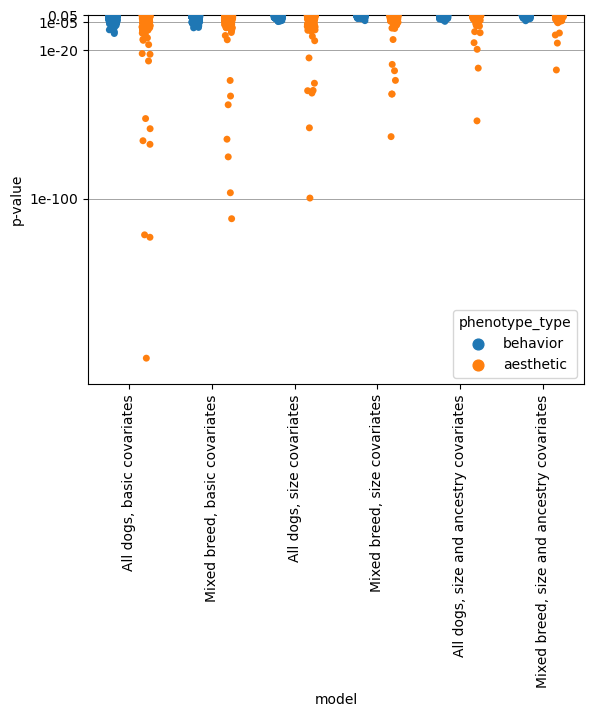

In [281]:
ordered = ['All dogs, basic covariates', 'Mixed breed, basic covariates',
           "All dogs, size covariates",
          "Mixed breed, size covariates",
          "All dogs, size and ancestry covariates",
          'Mixed breed, size and ancestry covariates']

g = sns.stripplot(data=results_stacked, x="model", y="p-value", hue = "phenotype_type", dodge=True, order=ordered)
g.set_yscale("log")

# the non-logarithmic labels you want
ticks = [1e-100, 1e-20, 0.00001, 0.05]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
g.set_ylim([1e-200, 0.1])
plt.xticks(rotation=90)
plt.axhline(y=0.00001, color = 'gray', linewidth = 0.5) 
plt.axhline(y=1e-20, color = 'gray', linewidth = 0.5) 
plt.axhline(y=1e-100, color = 'gray', linewidth = 0.5) 

plt.savefig("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/pvalues_of_LRT_by_model_and_phenotype.png", 
            bbox_inches='tight',
            dpi=300)

# Make dataframe of p-values from various GWAS runs at these target sites:

In [113]:
stacked = pd.read_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/target_SNPs_GWAS_associations.txt",
                      sep="\t",
                      header=None,
                      names = ["Chr", "SNP", "bp", "A1", "A2", "Freq", "b", "se", "p"])
stacked[["GWAS","Sep", "Chr"]] = stacked["Chr"].str.rpartition(".loco.mlma:",  expand = True)
stacked["GWAS"] = stacked["GWAS"].str.replace("/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/association/","")
stacked = stacked[stacked.SNP.isin(all_sites)]

In [ ]:
df = stacked.pivot(index = ['SNP'], columns = 'GWAS', values = 'p')
df.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/target_SNP_GWAS_pvalues.csv")